In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import pandas as pd
from pybedtools import BedTool
sys.path.append('/Users/IEO5559/Desktop/misc/splice/script')
import spl
from math import ceil
import pickle

# params and preprocessing

for the processing below, in general take care, might need to extract params first to see the sample boundaries to make sure the datamatrix fields are extracted correctly, below is assumed that computematrix was run with before=1000 and after=75000. Can check 'params' and re-rerun if necessary

In [2]:
def read(fname):
    matrix = subprocess.run(["gunzip", "-c", fname], capture_output=True, text=True)
    int1 = subprocess.run(["tail", "-n", "+2"], input=matrix.stdout, capture_output=True, text=True)
    datamatrix = subprocess.run(["cut", "-f", "7-43000"], input=int1.stdout, capture_output=True, text=True)
    data = [i.split("\t") for i in datamatrix.stdout.split("\n")]
    TSS = np.array(data[:-1], dtype=float)     #because of the final newline character
    meta = subprocess.run(["head", "-n", "1"], input=matrix.stdout, capture_output=True, text=True)
    params = meta.stdout 
    print(params)
    
    intermed = subprocess.run(["cut", "-f", "4"],capture_output=True, input=matrix.stdout, text=True)
    regions = subprocess.run(["tail", "-n", "+2"], input=intermed.stdout, capture_output=True, text=True)
    regionlist = regions.stdout.split("\n")[:-1]      #the final newline character
    print(len(regionlist))
    
    bed = subprocess.run(["cut", "-f", "1-6"],capture_output=True, input=matrix.stdout, text=True)
    bedint = subprocess.run(["tail", "-n", "+2"], input=bed.stdout, capture_output=True, text=True)
    bed = BedTool(bedint.stdout, from_string=True)
    beddf = pd.read_table(bed.fn, header=None)
    
    return TSS, regionlist, beddf

In [45]:
plus, list1, beddf1 = read("PROMPT_regions_siW_plus.tab.gz")
minus, list2, beddf2 = read("PROMPT_regions_siW_minus.tab.gz")
#bothstrands, regionlist, beddf = read("downs2ups20k/bothstrands_1kb.gz")

@{"upstream":[50,50,50,50,50,50],"downstream":[5000,5000,5000,5000,5000,5000],"body":[0,0,0,0,0,0],"bin size":[1,1,1,1,1,1],"ref point":["TSS","TSS","TSS","TSS","TSS","TSS"],"verbose":false,"bin avg type":"mean","missing data as zero":true,"min threshold":null,"max threshold":null,"scale":1,"skip zeros":true,"nan after end":false,"proc number":8,"sort regions":"keep","sort using":"mean","unscaled 5 prime":[0,0,0,0,0,0],"unscaled 3 prime":[0,0,0,0,0,0],"group_labels":["genes"],"group_boundaries":[0,372],"sample_labels":["87_for","88_for","89_for","90_for","siCtl_4sU_for","siWDR82_4sU_for"],"sample_boundaries":[0,5050,10100,15150,20200,25250,30300]}

372
@{"upstream":[50,50,50,50,50,50],"downstream":[5000,5000,5000,5000,5000,5000],"body":[0,0,0,0,0,0],"bin size":[1,1,1,1,1,1],"ref point":["TSS","TSS","TSS","TSS","TSS","TSS"],"verbose":false,"bin avg type":"mean","missing data as zero":true,"min threshold":null,"max threshold":null,"scale":1,"skip zeros":true,"nan after end":false,"proc n

In [64]:
bothstrands = np.append(plus, minus, axis=0)
regionlist = list1 + list2
beddf = pd.concat([beddf1, beddf2])
bps = 5050
xbins = list(range(bps))
numsamples = 6
labels = ['siCtl', 'siEXOSC3', 'siCtl IV polyA+', 'siEXOSC3 polyA+', '4sU control', '4sU siWDR82']
control_index = 0
binsize=1
thres_tag = 50
name_tag = "siW"

# begin

In [47]:
def split(matrix,bins_per_sample,num_samples):
    samples = [matrix[:,(bins_per_sample)*i:(bins_per_sample)*(i+1)] for i in range(num_samples)]
    return samples

def normalise(arr):
    if(np.max(np.array(arr).flatten(order='C'))!=0):
        return arr/(np.max(np.array(arr).flatten(order='C')))
    else:
        return arr

def allstop(profiles, bps, tholdcoeff=0.05, winsize=5):
	#takes i x j x k array
	indiv_stop = []
	indiv_start = []
	for i in profiles:
		err = []
		st = []
		for j in i:
			added=False
			thold = tholdcoeff*np.max(j)
			try:
				start = np.where(spl.csumsmooth(j,winsize)>thold)[0][0]
			except IndexError:
				start = 10
			st.append(start)

			try:
				ind = np.where(spl.csumsmooth(j[start+winsize:],winsize)<thold)[0][0]
				added=True
			except IndexError:
				ind = 10
				added=True
			if(ind==0):
				ind+=1
			err.append(ind+start)
			#for k in range(start+winsize,len(j)):
			#	if(np.mean(j[k-5:k+5]) < thold):
			#		err.append(k-start)
			#		added=True
			#		break
		indiv_start.append(st)
		indiv_stop.append(err)

	return indiv_start, indiv_stop

In [48]:
results = split(bothstrands ,bps,numsamples)

In [ ]:
averages = [np.mean(i,axis=0) for i in results]
for i in averages:
    plt.plot(i)

# bootstrap? lmao

In [90]:
##   randomly sample the bed, take the indices and subset results
bs = spl.randomly_sample_bed(beddf, 770, juncs=False, fromfile=False)

# simple smoothing

In [ ]:
smooth = [spl.csumsmooth(i,5) for i in averages]

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, gridspec_kw={'hspace': 0}, figsize=[10,3], sharey=True)
axs[0].plot(smooth[0], label=labels[0])
axs[0].plot(smooth[1], label=labels[1])

axs[1].plot(smooth[2], color='red', label=labels[2])
axs[1].plot(smooth[3], color='green', label=labels[3])

axs[2].plot(smooth[5], color='red', label=labels[5])
axs[2].plot(smooth[4], color='purple', label=labels[4])

axs[0].legend()
axs[0].set_xlabel('bases from TSS')
axs[1].legend()
axs[1].set_xlabel('bases from TSS')
axs[2].legend()
fig.suptitle('Antisense lncRNAs')

# calc

In [49]:
smoothagain = False
bootstrap = False

In [50]:
if(smoothagain):
    r2 = []
    for i in results:
        inner1 =[]
        for j in i:
            inner1.append(spl.csumsmooth(j,5))
        r2.append(inner1)
else:
    r2 = deepcopy(results)
if bootstrap:
    r2 = [[i[j] for j in bs.index.to_list()] for i in results]

In [77]:
allstart, berr = allstop(r2, bps=5050, winsize=100)

In [ ]:
spl.plotsome(250,None,r2[0],r2[1])

# res and vis

In [78]:
lens = []
for i in range(len(berr)):
    inn1 = []
    for j in range(len(berr[i])):
        inn1.append(berr[i][j]-allstart[i][j])
    lens.append(inn1)

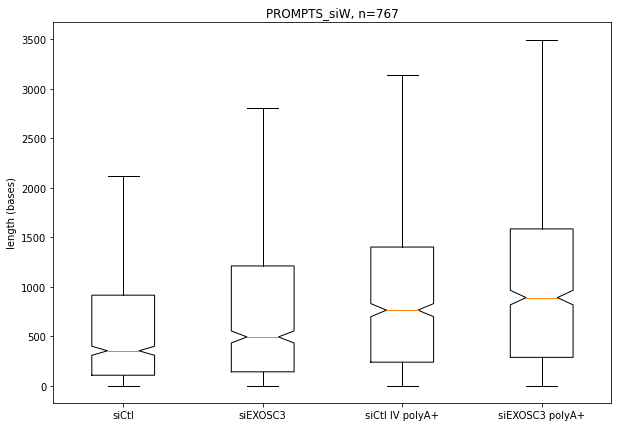

In [79]:
fig = plt.figure(figsize=(10,7))
plt.boxplot(lens[:4], showfliers=False, notch=True)
#plt.ylim([0,bps])
plt.title("PROMPTS_{0}, n={1}".format(name_tag,len(r2[0])))
plt.ylabel('length (bases)')
plt.xticks([1,2,3,4], labels[:4])
fig.patch.set_facecolor('white')
#plt.savefig('outputs/stopping_{0}_thr{1}.png'.format(name_tag, thres_tag))

# stuff and guys

In [80]:
indiv = list(zip(regionlist, r2[1], r2[1], r2[5], allstart[1],berr[1]))

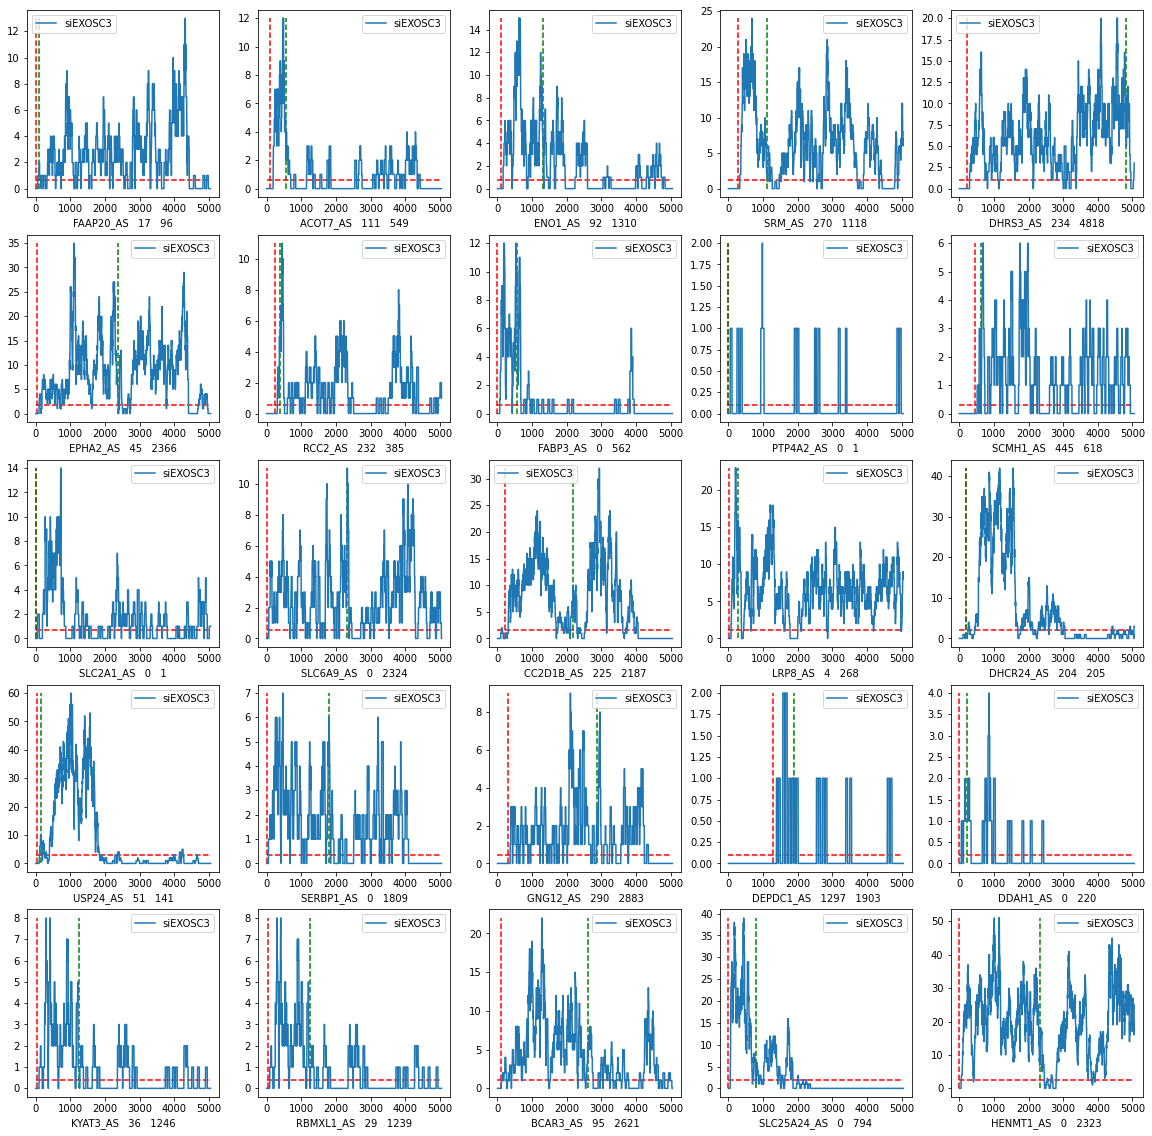

In [81]:
fig = plt.figure(figsize=(20,20))
start = 0
for i in range(start,start+25):
    plt.subplot(5,5,i+1-start)
    #plt.xticks([])
    plt.grid(False)
    plt.plot(indiv[i][2], label = labels[1])
    #plt.plot(indiv[i][2], label = labels[3])
    #plt.plot(indiv[i][3])
    plt.vlines(indiv[i][4],0,np.max(indiv[i][2]), color='red', linestyle='--')
    plt.vlines(indiv[i][5],0,np.max(indiv[i][2]), color='green', linestyle='--')
    #plt.xlabel("{0}   {1}   {2}".format(regionlist[i],indiv[i][4],indiv[i][5]))
    plt.xlabel("{0}   {1}   {2}".format(regionlist[i],indiv[i][4], indiv[i][5]))
    plt.hlines(0.05*np.max(indiv[i][1]),0,bps, color='red', linestyle='--')
    plt.legend()
fig.patch.set_facecolor('white')
plt.show()

# adjust the bed - polyA+ samples

In [71]:
pAbed = beddf.copy(deep=True)

In [72]:
### attention; allstart and berr contain the corrections. index 1 - siEXOSC3, index 3 - siEXOSC3_pA+
endpred = [i*binsize for i in berr[3]]
startpred = [i*binsize for i in allstart[3]]

#for plus strand, set the end coordinate to (start + berr), set the start to (start + allstart)
pAbed.iloc[:len(beddf1)-1,2] = pAbed.iloc[:len(beddf1)-1,1] + endpred[:len(beddf1)-1]
pAbed.iloc[:len(beddf1)-1,1] = pAbed.iloc[:len(beddf1)-1,1] + startpred[:len(beddf1)-1]

# for minus strand set the start coordinate to (end - berr), set the end coordinate to (end-allstart)
pAbed.iloc[len(beddf1):,1] = pAbed.iloc[len(beddf1):,2] - endpred[len(beddf1):]
pAbed.iloc[len(beddf1):,2] = pAbed.iloc[len(beddf1):,2] - startpred[len(beddf1):]

pAbed[1] = pAbed[1].astype(int)
pAbed[2] = pAbed[2].astype(int)
##add columns - want stopping point of control pA+ (index 2), and area under curve (both - indices 2 and 3)
pAbed['6'] = lens[2]
pAbed['7'] = lens[3]
pAbed['8'] = [np.sum(i) for i in r2[2]]
pAbed['9'] = [np.sum(i) for i in r2[3]]

In [73]:
pAbed.to_csv('outputs/pAbed_{0}_thr{1}.bed'.format(name_tag, thres_tag), header=False, index=False, sep= "\t")
#pAbed.to_excel('pAbed.xlsx', header=False, index=False)

# adjust the bed - NON-polyA+ samples

In [74]:
npAbed = beddf.copy(deep=True)

In [75]:
### attention; allstart and berr contain the corrections. index 1 - siEXOSC3, index 3 - siEXOSC3_pA+
endpred = [i*binsize for i in berr[1]]
startpred = [i*binsize for i in allstart[1]]

#for plus strand, set the end coordinate to (start + berr), set the start to (start + allstart)
npAbed.iloc[:len(beddf1)-1,2] = npAbed.iloc[:len(beddf1)-1,1] + endpred[:len(beddf1)-1]
npAbed.iloc[:len(beddf1)-1,1] = npAbed.iloc[:len(beddf1)-1,1] + startpred[:len(beddf1)-1]

# for minus strand set the start coordinate to (end - berr), set the end coordinate to (end-allstart)
npAbed.iloc[len(beddf1):,1] = npAbed.iloc[len(beddf1):,2] - endpred[len(beddf1):]
npAbed.iloc[len(beddf1):,2] = npAbed.iloc[len(beddf1):,2] - startpred[len(beddf1):]

npAbed[1] = npAbed[1].astype(int)
npAbed[2] = npAbed[2].astype(int)
##add columns - want stopping point of control (index 0), and area under curve (both - indices 0 and 1)
npAbed['6'] = lens[0]
npAbed['7'] = lens[1]
npAbed['8'] = [np.sum(i) for i in r2[0]]
npAbed['9'] = [np.sum(i) for i in r2[1]]

In [76]:
npAbed.to_csv('outputs/npAbed_{0}_thr{1}.bed'.format(name_tag, thres_tag), header=False, index=False, sep= "\t")
#npAbed.to_excel('npAbed.xlsx', header=False, index=False)

# pluck the chicken

In [ ]:
adbed = beddf.copy(deep=True)

In [ ]:
#take a window about the apparent 3' end, lets say... 500bp? 
#so, for plus strand set start cood to (end - 250), and set the end coord to (end + 250). for minus, set start to (start - 250) and end to (start + 250)
adbed.iloc[:len(beddf1)-1,1] = adbed.iloc[:len(beddf1)-1,2] - 250
adbed.iloc[:len(beddf1)-1,2] = adbed.iloc[:len(beddf1)-1,2] + 250

adbed.iloc[len(beddf1):,1] = adbed.iloc[len(beddf1):,1] - 250
adbed.iloc[len(beddf1):,2] = adbed.iloc[len(beddf1):,1] + 500

In [ ]:
rawseqs = [i.seq for i in spl.getfastas(adbed.iloc[:len(beddf1)-1,:])] + [i.antisense for i in spl.getfastas(adbed.iloc[len(beddf1):,:])]

In [ ]:
allcontent = [sum(spl.one_hot_encode(i)) for i in rawseqs]
allgc = [(i[1]+i[2])/sum(i) for i in allcontent]

In [ ]:
plt.boxplot(allgc, showfliers=False)
plt.show()

In [ ]:
##take 

extend = beddf.copy(deep=True)

extend.iloc[:len(beddf1)-1,2] = extend.iloc[:len(beddf1)-1,1] + 5000

extend.iloc[len(beddf1):,1] = extend.iloc[len(beddf1):,2] - 5000

In [ ]:
txs = [i.seq for i in spl.getfastas(extend.iloc[:len(beddf1)-1,:])] + [i.antisense for i in spl.getfastas(extend.iloc[len(beddf1):,:])]
txcode = [spl.one_hot_encode(i) for i in txs]

In [ ]:
#10 bp sliding window GC content
gcc = []
for i in range(len(txcode[2])):
    win = sum(txcode[2][i:i+10])
    gcc.append((win[1]+win[2])/10)

In [ ]:
plt.plot(gcc[:])
plt.ylim([0,1])
plt.ylabel('GC content in 500bp windows')
#plt.xticks([0,10000,20000,30000,40000,50000], [0,10,20,30,40,50])
plt.show()

In [ ]:
with open('apparent_cleavage_point.fa','w') as f:
    for i in range(len(rawseqs)):
        f.write(">{0}".format(i))
        f.write("\n")
        f.write(rawseqs[i])
        f.write("\n")

# write the lengths into a pickled file to read into somewhere else for plotting... fucking stupid, I know, but I'll do something about it later

In [101]:
with open('outputs/lens_{0}_thr{1}.pickle'.format(name_tag, thres_tag), 'wb') as f:
    pickle.dump(lens,f)